# Testing for Task 3

In [38]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

## Q-Learning Implementation (without VFA)

##### MDP Parameters

In [39]:
# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

##### Utility

In [40]:
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    print("\nQ-values for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(Q[comp_type])

##### Transition probabilities

In [ ]:
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

##### $\epsilon$-greedy action determination

In [50]:
def choose_action(Q, comp_type, s, xi, epsilon):
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        return np.argmax(Q[comp_type][:, s])

##### Q-Learning

In [ ]:
def run_QLearning(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    #* Initialize Q(s, a), ∀ s ∈ S, a ∈ A(s), arbitrarily
    Q = tuple(np.zeros((2, x + 1)) for x in xi)
    

    # Initialize other things    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    #* Repeat (for each episode):
    for i in tqdm(range(nEpisodes), desc="Episodes"):

        # Decaying learning rate
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))

        #* Initialize S
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
                
        # init max TD error
        max_TD_error = 0
        
        #* For Repeat (for each step of episode):
        for _ in range(0, lengthEpisode):

            #* Choose A from S using policy derived from Q using e-greedy
            a = choose_action(Q, comp_type, s, xi, epsilon)

            #* Take action A, observe S', comp_type'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            #* Take action A, observe R
            r = -C[comp_type][s][a]
            
            #* Q-Learning Update:
            #* Q(S, A) <- Q(S, A) + α[R + γ*max_a{Q(S', a)} – Q(S, A)]
            if s_prime == xi[comp_type_prime]:
                maxNextQ = Q[comp_type_prime][1,s_prime]
            else:
                maxNextQ = np.max(Q[comp_type_prime][:,s_prime])
            TD_error = r + gamma* maxNextQ - Q[comp_type][a][s]
            # update Q-value
            Q[comp_type][a][s] += alpha * TD_error

            # update max TD error
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)
            
            #* S <- S'
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # Early stopping based on stable policy
        if patience is not None:
            current_policy = tuple(np.argmax(Q[comp], axis=0) for comp in range(len(Q)))
            # Force maintenance at the threshold, bc forcing action 1 at th in choose_action(.)
            for k, policy in enumerate(current_policy):
                policy[xi[k]] = 1
            
            #
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD convergence
        if(max_TD_error) < delta:
            return TD_errors, Q
    
    return TD_errors, Q

Best Trial

Episodes:   3%|▎         | 3064/100000 [01:55<1:01:03, 26.46it/s]


Stopped early at episode 3065 — policy stable for 200 episodes.


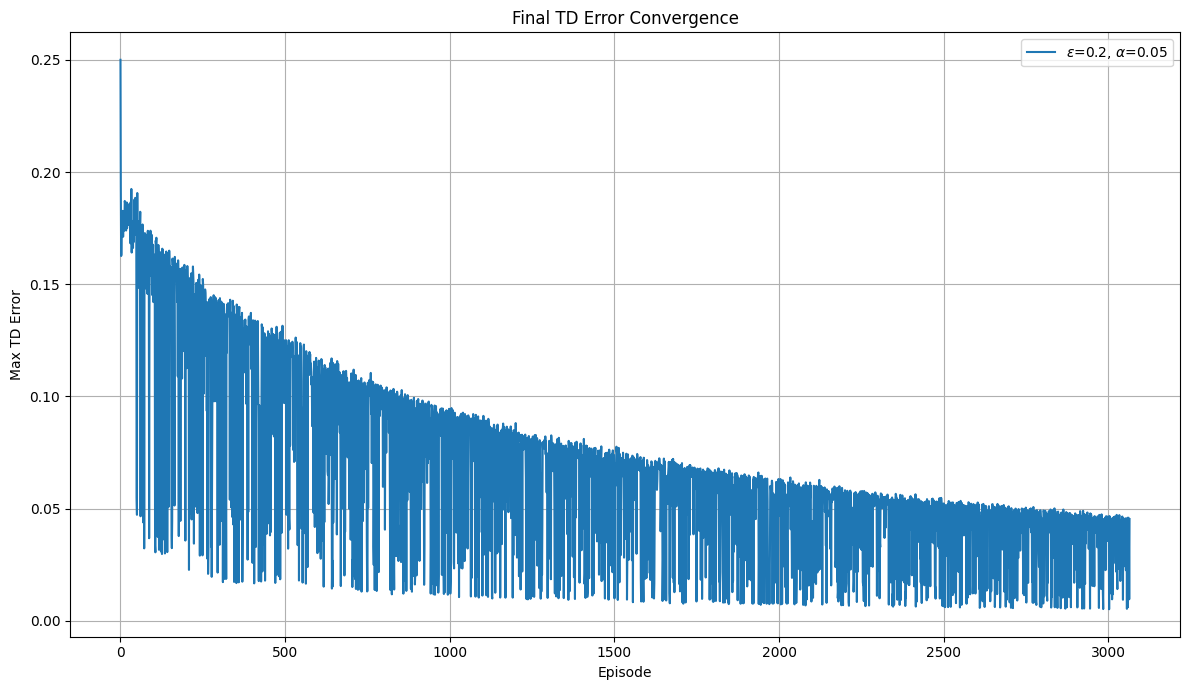

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1]

Q-values for each Component Type:
Component Type 1 (Failure Threshold = 15):
[[-0.92567255 -1.00780861 -1.00641252 -1.0828334  -1.14512522 -1.18007814
  -1.26993091 -1.30168038 -1.56129875 -1.65614112 -1.82411622 -2.15183183
  -2.44031676 -2.86608024 -2.96524154  0.        ]
 [-1.43293249 -1.48140499 -1.47872396 -1.43645834 -1.50420427 -1.4382819
  -1.44875377 -1.45385833 -1.46103291 -1.51130095 -1.46930075 -1.48630843
  -1.4454347  -1.49471973 -1.48301598 -5.45760824]]
Component Type 2 (Failure Threshold = 30):
[[-0.47625716 -0.48202064 -0.51246533 -0.54792842 -0.57513246 -0.58608705
  -0.62830047 -0.6663463 

In [59]:
nEpisodes = pow(10, 5)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.2
initial_alpha = 0.05
decay_rate=10_000

td_errors, Q = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(Q)

Another trial

Episodes:  12%|█▏        | 11650/100000 [07:10<54:23, 27.08it/s]  


Stopped early at episode 11651 — policy stable for 200 episodes.


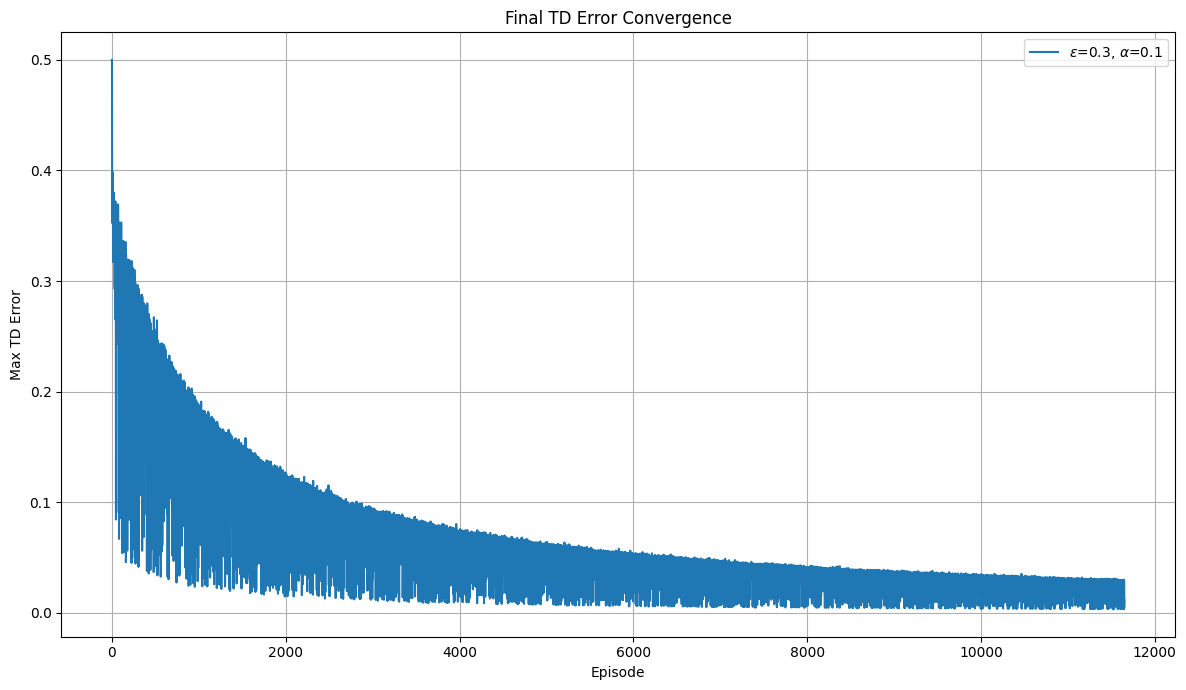

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1]

Q-values for each Component Type:
Component Type 1 (Failure Threshold = 15):
[[-0.96407718 -1.00155643 -1.0491885  -1.11611525 -1.14502808 -1.22331854
  -1.26423443 -1.34212368 -1.50249354 -1.71874696 -1.97516257 -2.23702232
  -2.73283397 -2.8849621  -3.13263407  0.        ]
 [-1.50067785 -1.47339929 -1.46596744 -1.45566401 -1.4815257  -1.4699681
  -1.48989712 -1.49275084 -1.46662789 -1.45190293 -1.48172601 -1.46655652
  -1.49438195 -1.47925556 -1.45791997 -5.48035093]]
Component Type 2 (Failure Threshold = 30):
[[-0.45244096 -0.47623809 -0.50524028 -0.51842304 -0.55295147 -0.57159746
  -0.59832085 -0.6347779 

In [ ]:
nEpisodes = pow(10, 5)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.3
initial_alpha = 0.1
decay_rate=20_000

td_errors, Q = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(Q)